<a href="https://colab.research.google.com/github/shelcia/GPR/blob/main/landmine_gpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/polimi-ispl/landmine_detection_autoencoder.git

Cloning into 'landmine_detection_autoencoder'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.


In [ ]:
!cp /content/drive/MyDrive/20170621_deg0_HHVV.npy /content/data/

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=1c65c60acef9d1127d195a91ea4154088eca0b5a4e4ce63454d74a04e62edb45
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
!git clone https://github.com/polimi-ispl/python_patch_extractor

Cloning into 'python_patch_extractor'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 105 (delta 23), reused 21 (delta 7), pack-reused 61
Receiving objects: 100% (105/105), 1.57 MiB | 23.34 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from landmine_detection_autoencoder import PreProcessing
from landmine_detection_autoencoder import net
from python_patch_extractor import PatchExtractor

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

GPU selected: 0


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


In [ ]:
in_path = 'data/20170621_deg0_HHVV.npy'
out_path = 'OP'
architecture = 'Auto3D2'
ny = 3 # number of adjacent B-scans to be considered
data_augmentation = True
preprocessing = 'normalize'
patch_size = 64
patch_stride = 4
n_bsc = 5 # number of B_scans for training

In [ ]:
def parse_pp(string):
    return getattr(PreProcessing, string)

def parse_net(string):
    return getattr(net, string)

In [ ]:
if not os.path.exists(out_path):
    os.makedirs(out_path)

field, campaign = in_path.split('/')
campaign, extension = campaign.split('.')

# **Loading Data**

In [ ]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [ ]:
dataset = np.load(in_path).item()

train_bsc_idx = np.where(np.asarray(dataset['ground_truth']) == 0)[0][:n_bsc]
trainset = dataset['data'][train_bsc_idx]
trainset = np.moveaxis(trainset, np.argmin(trainset.shape), -1)
del dataset

In [ ]:
if patch_size is not None:
    patch_size = (patch_size, patch_size)
else:
    patch_size = trainset.shape[1:]

patch_size = patch_size + (ny,)
patch_stride = (patch_stride, patch_stride, 1)

pe = PatchExtractor.PatchExtractor(patch_size, stride=patch_stride)
train_patches = pe.extract(trainset)
# reshaping
train_patches = train_patches.reshape((-1,) + patch_size)

# preprocessing each patch
train_patches, min_tr, max_tr = PreProcessing.apply_transform(train_patches, transform=parse_pp(preprocessing))

# Data augmentation (default=True)
if data_augmentation:
    train_patches = np.concatenate([train_patches, np.flip(train_patches, axis=2).copy()], axis=0)

train_patches = shuffle(train_patches)

# create training and validation sets
train_patches, val_patches, train_index, val_index = train_test_split(train_patches,
                                                                      np.arange(train_patches.shape[0]),
                                                                      test_size=0.5,
                                                                      random_state=118
                                                                      )

In [ ]:
sets = net.Settings()
patience = sets.patience
lr_factor = sets.lr_factor
batch_size = sets.batch_size
epochs = sets.epochs

autoencoder, encoder = parse_net(architecture)(patch_size)

out_name = field+'_'+campaign+'_'+architecture+'_patch'+str(patch_size[0])+'_stride'+str(patch_stride[0])+'_bsc'+str(n_bsc)+'_ny'+str(ny)

lr_chkpt = ReduceLROnPlateau(monitor='val_loss',
                             factor=lr_factor,
                             patience=patience//2,
                             verbose=0,
                             mode='auto',
                             epsilon=0.0001,
                             cooldown=0,
                             min_lr=0)
save_chkpt = ModelCheckpoint(os.path.join(out_path, out_name+'.h5'),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
stop_chkpt = EarlyStopping(monitor='val_loss',
                           patience=patience)

#train_acc = History()

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_in_0 (InputLayer)          (None, 64, 64, 3)         0         
_________________________________________________________________
g_conv_0 (Conv2D)            (None, 64, 64, 16)        1744      
_________________________________________________________________
g_conv_1 (Conv2D)            (None, 32, 32, 16)        6416      
_________________________________________________________________
g_conv_2 (Conv2D)            (None, 16, 16, 16)        4112      
_________________________________________________________________
g_conv_3 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 16)          1040      
_________________________________________________________________
encoder (Conv2D)             (None, 2, 2, 16)          272 

In [ ]:
train = autoencoder.fit(train_patches, train_patches,
                        validation_data=(val_patches, val_patches),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[save_chkpt, stop_chkpt, lr_chkpt])
print('Training done!')



Epoch 00001: val_loss improved from inf to 0.02510, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00002: val_loss improved from 0.02510 to 0.01929, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00003: val_loss improved from 0.01929 to 0.01607, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00004: val_loss improved from 0.01607 to 0.01490, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00005: val_loss improved from 0.01490 to 0.01415, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00006: val_loss improved from 0.01415 to 0.01371, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00007: val_loss improved from 0.01371 to 0.01347, saving model to OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3.h5

Epoch 00008: val_loss improved from 0.01347 to 0.0

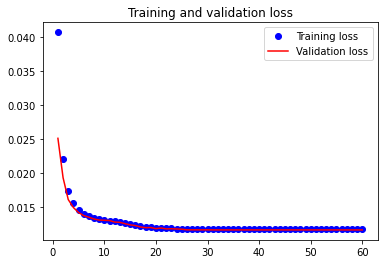

In [ ]:
train_loss = train.history['loss']
val_loss = train.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from tqdm import tqdm

In [ ]:
training = '/content/OP/data_20170621_deg0_HHVV_Auto3D2_patch64_stride4_bsc5_ny3'
net_weights = training + '.h5'

##Test

In [ ]:
train_path = in_path
dataset = np.load("/content/data/20170621_deg0_HHVV.npy").item()

# preprocessing
data = dataset['data']

# patch extractor
pe = PatchExtractor.PatchExtractor(patch_size, stride=patch_stride)

# background bscans for training
gt = np.asarray(dataset['ground_truth'])
del dataset

test_idx = np.arange(data.shape[0])
# check whether the test dataset is the same of the training
if in_path == train_path:
    train_idx = np.where(gt == 0)[0][:n_bsc]
    test_idx = np.delete(test_idx, train_idx)
testset = data[test_idx]
gt = gt[test_idx]
del data
testset = np.moveaxis(testset, np.argmin(testset.shape), -1)

NameError: ignored

In [ ]:
autoencoder, encoder = parse_net(architecture)(patch_size)
autoencoder.load_weights(os.path.join(net_weights))

out_name = field+'_'+campaign+'_'+architecture+'_patch'+str(patch_size[0])+'_stride'+str(patch_stride[0])+'_bsc'+str(n_bsc)+'_ny'+str(ny)

In [ ]:
patches = pe.extract(testset)
patchesIdx = patches.shape
patches_hat = autoencoder.predict(patches.reshape((-1,) + patch_size))
mseFeat = (encoder.predict(patches.reshape((-1,) + patch_size)) - encoder.predict(patches_hat))**2
mseFeat_patches = np.zeros(patches_hat.shape) + np.mean(mseFeat, axis=(1,2,3)).reshape((-1,1,1,1))
del patches
del patches_hat
del mseFeat
mseFeat_vol = pe.reconstruct(mseFeat_patches.reshape(patchesIdx))
del mseFeat_patches

In [ ]:
mse_mask_max = np.max(mseFeat_vol, axis=(0, 1))
fpr_max, tpr_max, thresholds_max = roc_curve(gt, mse_mask_max)
roc_auc_max = roc_auc_score(gt, mse_mask_max)
print('best AUC = %0.2f' % roc_auc_max)

In [ ]:
cm = confusion_matrix(gt, mse_mask_max)

In [ ]:
import pandas as pd
conf = pd.read_csv('model_output.csv')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

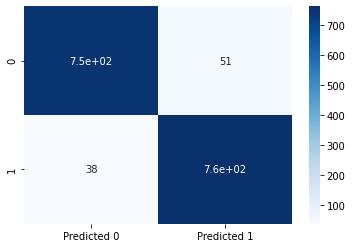

In [ ]:
import seaborn as sns
sns.heatmap(conf,annot=True,cmap='Blues')

In [ ]:
conf

,Predicted 0,Predicted 1
0,749,51
1,38,762


In [ ]:
TP = conf.iloc[0,0]
FP = conf.iloc[0,1]
TN = conf.iloc[1,1]
FN = conf.iloc[1,0]

In [ ]:
Accuracy = (TP+TN)/(TP+FP+FN+TN)
Precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
F1_Score = 2*(Sensitivity * Precision) / (Sensitivity + Precision)
Specificity = TN/(TN+FP)

In [ ]:
print("Accuracy = ", Accuracy)
print("Precision = ", Precision)
print("Sensitivity = ", Sensitivity)
print("F1_Score = ", F1_Score)
print("Specificity = ",Specificity)

Accuracy =  0.944375
Precision =  0.93625
Sensitivity =  0.951715374841169
F1_Score =  0.9439193446754883
Specificity =  0.9372693726937269
